## PREP-1: Install bgfc_kit package from github 
- Install instructions can be found on the repo

In [1]:
!pip install git+https://github.com/peetal/bgfc_kit.git

  Cloning https://github.com/peetal/bgfc_kit.git to /tmp/pip-req-build-u3na5dxa
  Running command git clone --filter=blob:none --quiet https://github.com/peetal/bgfc_kit.git /tmp/pip-req-build-u3na5dxa
  Resolved https://github.com/peetal/bgfc_kit.git to commit 8dbce79bce49aaf5195a33846dc0e8f6a7dcf79e
  Preparing metadata (setup.py) ... done
  Created wheel for bgfc-kit: filename=bgfc_kit-1.0.0-py3-none-any.whl size=16875 sha256=c838ac879ca166b0a15568e5edf85e0293012f305118e6592902d801613467d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-kne04beh/wheels/3e/e1/81/7dd1be24bc71a9a51a9aa83b1d8adb5f7618e5a3a44ba84e42
Successfully built bgfc-kit

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


- Here we can see that the package has been successfully installed, and we can also check the submodules of the package.

In [3]:
import bgfc_kit, importlib, inspect, pkgutil, os
package = importlib.import_module('bgfc_kit')
print(f"Submodules of bgfc_kit:")
for loader, name, is_pkg in pkgutil.walk_packages(package.__path__):
    print(f"- {name}")

Submodules of bgfc_kit:
- bgfc_analyses
- fir_design_matrix
- preprocessing_pipeline
- structDict


## PREP-2: Dummy experimental Design 
- Here I introduce a dummy exprimental design that mirror the design of Chapter 3, the goal is demonstrate how to use `bgfc_kit` for backgrounf connectivity analyses
- 6 conditions, 2 functional runs per condition; 8 epochs (of the same condition) per functional run.
- Run structure: 6 TR leading-in + 40 TR/epoch * 8 epoch + 6 TR leading-out -> 332 TR/run 
- Epoch structure: 4 TR instruction + 24 TR tasks + 12 TR IBI -> 40 TR/epoch
- We chose to use FIR to model the first 36 TR of each epoch of each condition -> 36 TR * 6 condition = 216 regressors

## 1. Finite impulse response (FIR) model design matrix 
#### 1.1 Creating configuration file template
- Generating the FIR model design matrix needs many specific inforamtion about the task design. These information can be too chunky to include in a single function. 
- So you can first create an empty configuration file with all necessary parameters to generate the design matrix. After you fill it out, it can be reused to generate FIR model design matrices easily.
- Here we can use `generate_FIRdesignMat_template_toml` function from `bgfc_kit.fir_design_matrix` to generate a template of configuration file.

In [14]:
from bgfc_kit.fir_design_matrix import generate_FIRdesignMat_template_toml
# generate an the template configuratio file
output_dir = '/projects/hulacon/peetal/bgfc_kit_test/'
generate_FIRdesignMat_template_toml(output_dir)

- Let's have a quick look at the configuration file template
    - The `PARAMETERS` are empty and will take your inputs that are specific to your experiment design. 
    - The `COMMENTS` explains what each parameter is.
  
      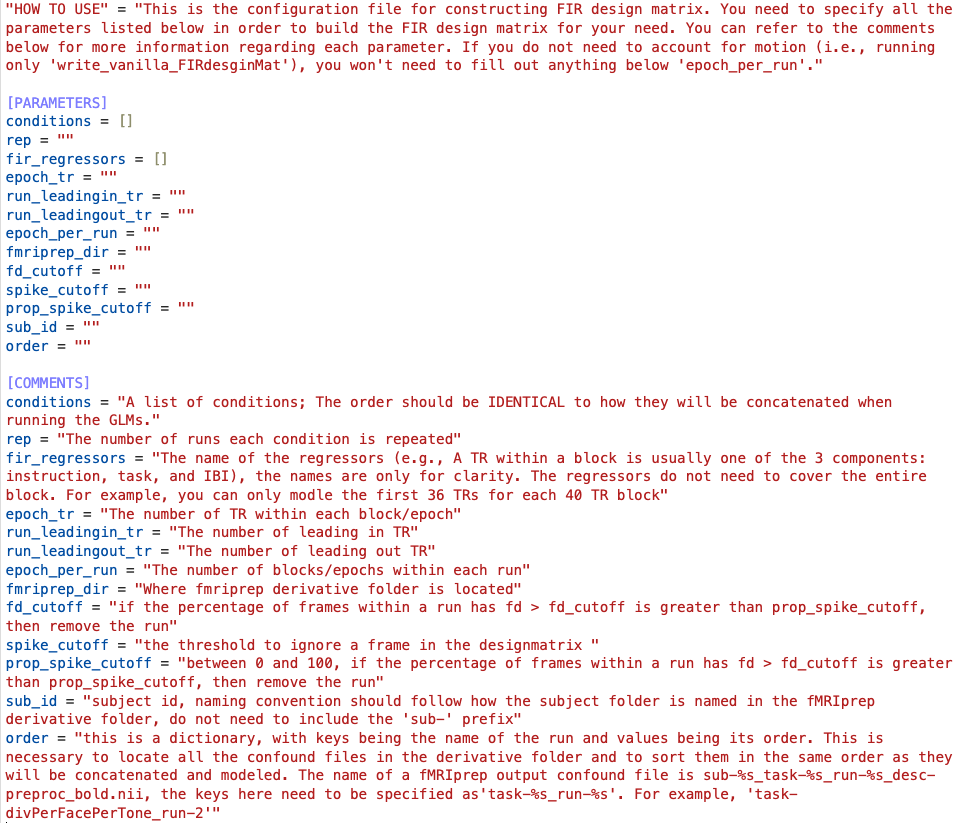


#### 1.2 Generating FIR model design matrix for a subject 
- The `write_personalized_FIRdesignMat` takes account of excessive motion and remove bad frame or runs (such as the last run in the current case. 
- Simpler version `write_vanilla_FIRdesignMat` can be used if no need to consider motions.
- This function writes out the design matrix to the output directory and also plot the corresponding heatmap for visual inspection.
    - Each role is a TR, there are 332 TR/run * 12 run = 3984 TR.
    - Each column is a FIR regressor, each regressor models a TR of all epochs within the same condition. As suggested in the dummy design, we model the first 36 TR of all epochs, and there are 6 conditions, and thus we have 216 FIR regressors.
    - Note that due to the size of the figure, not all names of the regressors were shown. 


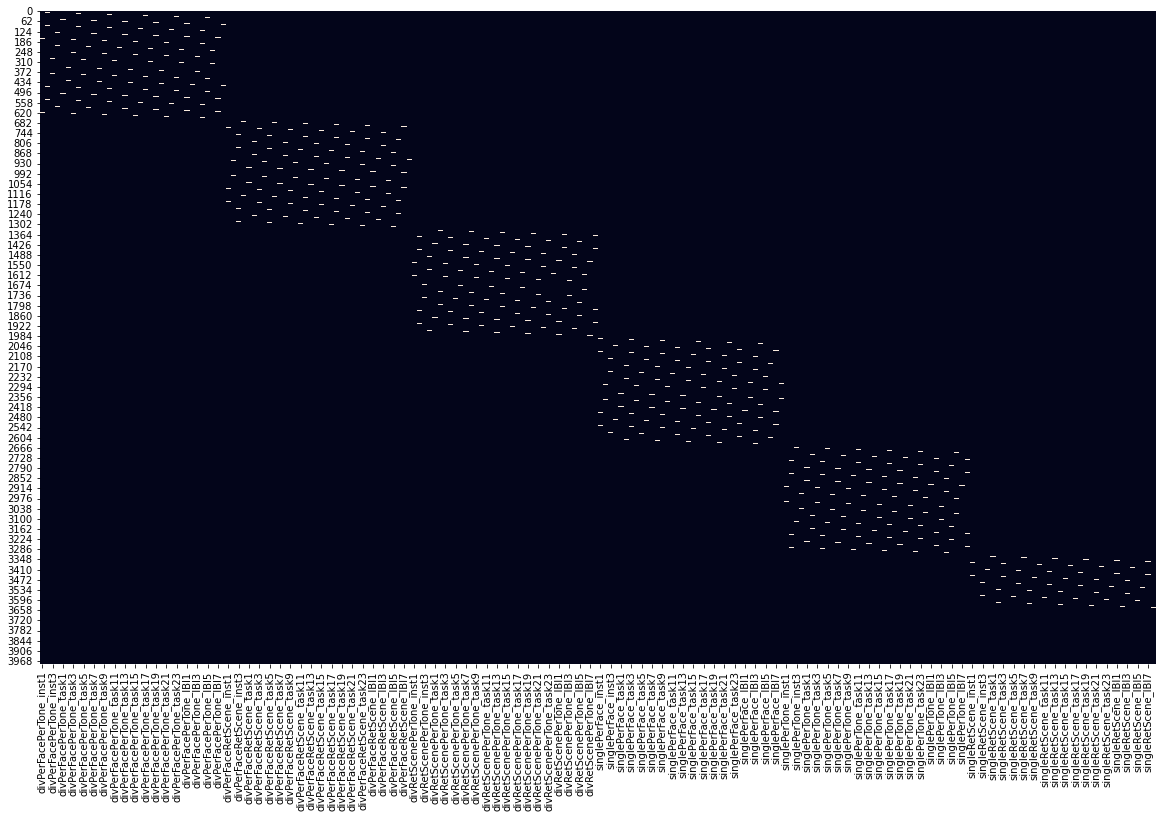

In [38]:
from bgfc_kit.fir_design_matrix import write_personalized_FIRdesginMat
cfg_dir = '/projects/hulacon/peetal/bgfc_kit_test/FIRdesignMat_conf_filled.toml'
write_personalized_FIRdesginMat(cfg_dir, output_dir)

## 2. BGFC preprocessing pipeline

The module within BGFC-kit responsible for extracting the residual timeseries is intended to complement the preprocessing pipeline of fMRIprep (Esteban et al., 2019). Utilizing the minimally preprocessed NIFTI files and the confound parameter estimates generated by fMRIprep, BGFC-kit carries out additional preprocessing steps. These steps include: 
1) smoothing and filtering (orange box)
2) applying a first general linear model (GLM) to eliminate nuisance regressors (blue box)
3) demeaning and concatenation (green box) 
4) employing a second GLM to eliminate stimulus-evoked activities (pink box)

The outputs of BGFC-kit preprocessing pipeline includes 4 important components: 
1) the "residual" timeseries, which can then be used for computing background functional connectivity
2) the "evoked" timeseries, which is the concatenated timeseries prior to the second GLM
3) the parameter estimates of the second GLM, which can be used to perform sanity check
4) a brain mask for the subject shared across all fMRI functional runs.

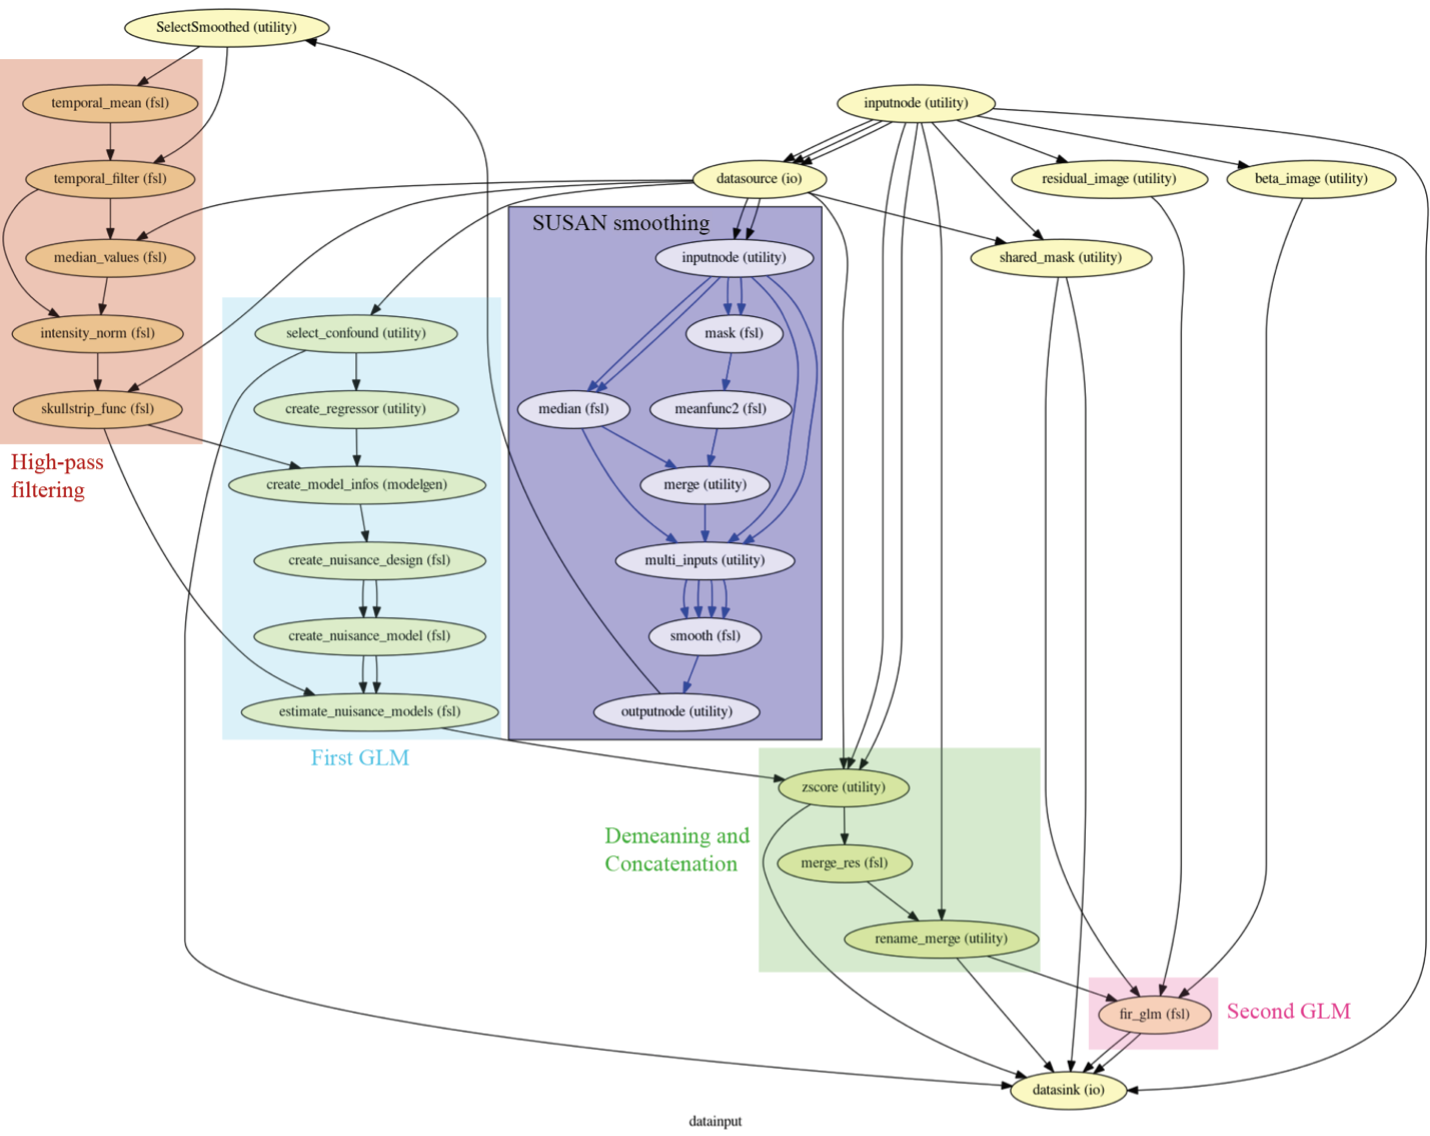

#### 2.1 Creating configuration file template
- Running this postfMRIprep pipeline needs many specific inforamtion about the task design. These information can be too chunky to include in a single function. 
- So you can first create an empty configuration file with all necessary parameters for running the pipeline. After you fill it out, it can be reused to generate FIR model design matrices easily.
- Here we can use `generate_postfMRIprep_pipeline_template_toml` function from `bgfc_kit.preprocessing_pipeline` to generate a template of configuration file.

In [43]:
from bgfc_kit.preprocessing_pipeline import generate_postfMRIprep_pipeline_template_toml
generate_postfMRIprep_pipeline_template_toml(output_dir)

- Let's have a quick look at the configuration file template
    - The `PARAMETERS` are empty and will take your inputs that are specific to your experiment design. 
    - The `COMMENTS` explains what each parameter is.
      
        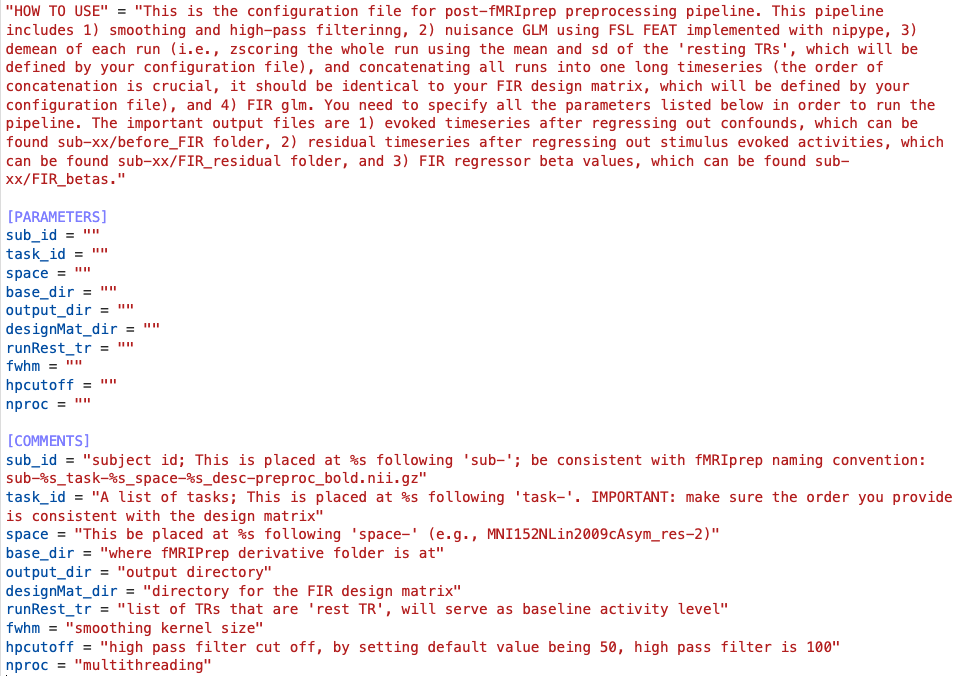

#### 2.2 Submit SLURM job to talapas

- This feature is specifically useful for talapas users. The `submit_postfMRIprep_pipeline_SLURM` function from `bgfc_kit.preprocessing_pipeline` will write out a shell script and submit a slurm job automatically through subprocess.
- We can examine or edit the shell script automatically generated by this function if necessary.

In [2]:
from bgfc_kit.preprocessing_pipeline import submit_postfMRIprep_pipeline_SLURM
cfg_dir = '/projects/hulacon/peetal/bgfc_kit_test/postfMRIprep_pipeline_config_filled.toml'
shell_dir = '/projects/hulacon/peetal/bgfc_kit_test/submit_postfMRIprep_test.sh'
submit_postfMRIprep_pipeline_SLURM(cfg_dir, shell_dir, "hulacon", "fat", "post_fmriprep", "100GB")

Bash script submitted successfully.
Job ID: Submitted batch job 29548876


In [44]:
with open('/projects/hulacon/peetal/bgfc_kit_test/submit_postfMRIprep_test.sh', 'r') as file:
    script_content = file.read()

# Print the content of the shell script
print(script_content)

#!/bin/bash
#SBATCH --account=hulacon
#SBATCH --partition=fat  
#SBATCH --job-name=post_fmriprep  
#SBATCH --mem=100GB
#SBATCH --time=1-00:00:00
#SBATCH --output=%x_%A_%a.log

module load fsl
module load ants
module load miniconda
module load singularity
conda activate jupyterlab-tf-pyt-20211020

python3 /gpfs/projects/hulacon/peetal/bgfc_kit/bgfc_kit/scripts/post_fMRIPrep_pipeline.py --sub-id 001 --task-id divPerFacePerTone_run-1 divPerFacePerTone_run-2 divPerFaceRetScene_run-1 divPerFaceRetScene_run-2 divRetScenePerTone_run-1 divRetScenePerTone_run-2 singlePerFace_run-1 singlePerFace_run-2 singlePerTone_run-1 singlePerTone_run-2 singleRetScene_run-1 singleRetScene_run-2  --space T1w --base-dir /projects/hulacon/peetal/divatten --output-dir /projects/hulacon/peetal/bgfc_kit_test/preprocessed_data --designMat-dir /projects/hulacon/peetal/bgfc_kit_test/fir_design_matrix.txt --run-restTR 38 39 40 41 42 43 44 45 46 47 48 49 78 79 80 81 82 83 84 85 86 87 88 89 118 119 120 121 122 123 124 1

#### 2.3 Examine the outputs from the postfMRIprep pipeline
- Once the job is done, we can examine the key outputs from this pipeline.
1) the "residual" timeseries -> `FIR_residual/sub-001_res.nii.gz`
2) the "evoked" timeseries -> `before_FIR/sub-001_nuisanceRes_CONCAT.nii.gz`
3) the parameter estimates of the second GLM -> `FIR_betas/sub-001_beta.nii.gz`
4) a brain mask for the subject shared across all fMRI functional runs -> `task_shared_mask/sub-001_task-shared_brain-mask.nii.gz`

In [39]:
!tree /projects/hulacon/peetal/bgfc_kit_test/preprocessed_data/sub-001

/projects/hulacon/peetal/bgfc_kit_test/preprocessed_data/sub-001
├── FIR_betas
│   └── sub-001_beta.nii.gz
├── FIR_residual
│   └── sub-001_res.nii.gz
├── before_FIR
│   └── sub-001_nuisanceRES_CONCAT.nii.gz
├── nuisance_regressor
│   ├── sub-001_task-divPerFacePerTone_run-1_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-divPerFacePerTone_run-2_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-divPerFaceRetScene_run-1_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-divPerFaceRetScene_run-2_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-divRetScenePerTone_run-1_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-divRetScenePerTone_run-2_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-singlePerFace_run-1_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-singlePerFace_run-2_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-singlePerTone_run-1_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-

## 3. Sanity check 
- FIR estimates can be used for sanity check.
- Using the `plot_parcel_FIR_estimates` function from `bgfc_kit.bgfc_analyses`, we will be able to plot the FIR estimates for any parcel of interests. Importantly, with the current dummy experimental design, the 216 FIR regressors models 6 types of epochs, with each type of epoch including 24 TR task and 12 TR rest. Consequently, if everything goes well, we should be able to observe boxcart structure when we plot out the estimates.
- Here I used the Schaefer 200 predefined parcellation scheme, and selected 2 parcels to look at, parcel1 is in the visual network, parcel 81 is in the default mode network. Note that the selection of the parcellation scheme and parcels are completely up to the user. 

In [4]:
from bgfc_kit.bgfc_analyses import plot_parcel_FIR_estimates
# specify the necessary inputs
FIRdesignMat_conf_dir = '/home/peetal/hulacon/bgfc_kit_test/FIRdesignMat_conf_filled.toml'
postfMRIprep_conf_dir = '/home/peetal/hulacon/bgfc_kit_test/postfMRIprep_pipeline_config_filled.toml'
atlas = os.path.join('/projects/hulacon/peetal/divatten/post_fMRIPrep_pip_motionCorr', f"sub-001", "transformed_atlas", f"sub-001_schaefer200_T1W.nii.gz")
subject_list = [1] # we only look at the first subject we have just preprocessed
plot_parcel_FIR_estimates(FIRdesignMat_conf_dir, postfMRIprep_conf_dir, 1, [1], atlas)

NameError: name 'toml' is not defined

In [36]:
# FIRdesignMat_conf_dir = '/home/peetal/hulacon/bgfc_kit_test/FIRdesignMat_conf_filled.toml'
# postfMRIprep_conf_dir = '/home/peetal/hulacon/bgfc_kit_test/postfMRIprep_pipeline_config_filled.toml'
# sub = [1]
# atlas = os.path.join('/projects/hulacon/peetal/divatten/post_fMRIPrep_pip_motionCorr', f"sub-001", "transformed_atlas", f"sub-001_schaefer200_T1W.nii.gz")
# activity_data = parcellate_rmMotion_batch(FIRdesignMat_conf_dir, postfMRIprep_conf_dir, sub, atlas)

In [63]:
single_epoch = define_epoch(FIRdesignMat_conf_dir, postfMRIprep_conf_dir)
sub_epoch = [single_epoch for i in range(1)]
raw_data, labels = separate_epochs(activity_data, sub_epoch)

In [65]:
cond1 = separate_epochs_per_condition(raw_data,labels,0,sub_epoch)
cond2 = separate_epochs_per_condition(raw_data,labels,1,sub_epoch)
cond3 = separate_epochs_per_condition(raw_data,labels,2,sub_epoch)
cond4 = separate_epochs_per_condition(raw_data,labels,3,sub_epoch)
cond5 = separate_epochs_per_condition(raw_data,labels,4,sub_epoch)
cond6 = separate_epochs_per_condition(raw_data,labels,5,sub_epoch)

In [81]:
# compute connectome for each epoch for all subjects, geting a list of epochs 
cond1_epochlevel_corMat = list(compute_epoch_cond_connectome_ztrans_nobadframe(cond1))
cond1_sublevel_corMat = list(compute_sub_cond_connectome_ztrans_nobadframe(cond1))

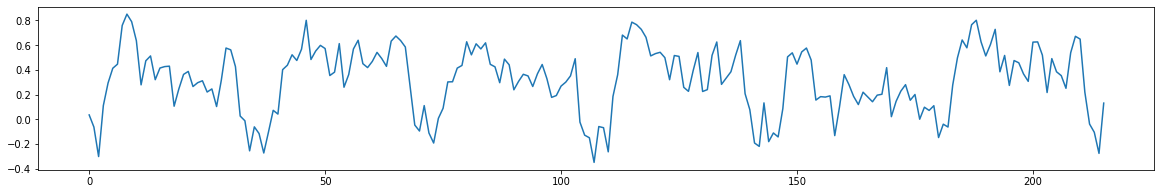

In [99]:
plot_parcel_FIR_estimates(FIRdesignMat_conf_dir, postfMRIprep_conf_dir, 1, [1], atlas)